# Range-Bound + Low Volatility Strategy for EUR/USD

Bollinger Bands + ATR

In [7]:
%matplotlib inline
import numpy as np
import backtrader as bt 
from datetime import datetime, timedelta
import os
import sys
import matplotlib
import matplotlib.pyplot as plt

In [8]:

class BollingerATRStrat(bt.Strategy):

    params = (
        ('atr_period', 14),  # ATR Lookback Period
        ('bb_period', 20),  # Bollinger Bands Lookback Period
        ('std', 2),  # Standard Deviation for Bollinger Bands
        ('atr_min', 0.00010),  # ATR minimum threshold
        ('atr_max', 0.00070),  # ATR maximum threshold
        ('risk_per_trade', 0.02),  # 2% risk per trade
        ('stop_buffer', 0.0004),  # Stop-loss buffer (4 pips)
        ('lot_size', 1000),  # Micro lot size (1,000 units per lot)
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f'{dt.isoformat()}, {txt}')
    
    def __init__(self):
        self.atr = bt.indicators.ATR(period=self.p.atr_period)
        self.bb = bt.indicators.BollingerBands(period=self.p.bb_period, devfactor=self.p.std)
        self.sma = bt.indicators.SimpleMovingAverage(period=self.p.bb_period)  # Midline of BB
        self.dataclose = self.datas[0].close

        self.order = None
        self.stop_loss = None
        self.take_profit = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED at {order.executed.price:.5f}')
            elif order.issell():
                self.log(f'SELL EXECUTED at {order.executed.price:.5f}')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'PROFIT: GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def next(self):
        self.log(f'Close: {self.dataclose[0]:.5f}')

        if not (self.p.atr_min <= self.atr[0] <= self.p.atr_max):
            return  # Skip trading if market is too volatile or too quiet

        if self.order:
            return  # If there's an open order, do nothing
        
        cash = self.broker.get_cash()
        risk_amount = cash * self.p.risk_per_trade  # 2% of account balance per trade
        stop_loss_distance = self.p.stop_buffer  # 4 pips (0.0004 in forex)

        # Calculate position size (adjusted for lot size and pip value)
        pip_value = 10  # Pip value for a standard lot ($10 per pip), adjust as needed
        position_size = int((risk_amount / (stop_loss_distance * pip_value)) * self.p.lot_size)

        if position_size <= 0:
            return  # Prevent zero or negative lot sizes

        if not self.position:
            # LONG ENTRY: Price touches lower Bollinger Band
            if self.data.close[0] <= self.bb.lines.bot[0]:
                stop_price = self.data.close[0] - stop_loss_distance
                take_profit_price = self.sma[0]
                self.log(f'BUY SIGNAL - Size: {position_size}, Stop: {stop_price:.5f}, TP: {take_profit_price:.5f}')
                self.order = self.buy(size=position_size)
                self.stop_loss = self.sell(size=position_size, exectype=bt.Order.Stop, price=stop_price)
                self.take_profit = self.sell(size=position_size, exectype=bt.Order.Limit, price=take_profit_price)
            
            # SHORT ENTRY: Price touches upper Bollinger Band
            elif self.data.close[0] >= self.bb.lines.top[0]:
                stop_price = self.data.close[0] + stop_loss_distance
                take_profit_price = self.sma[0]
                self.log(f'SELL SIGNAL - Size: {position_size}, Stop: {stop_price:.5f}, TP: {take_profit_price:.5f}')
                self.order = self.sell(size=position_size)
                self.stop_loss = self.buy(size=position_size, exectype=bt.Order.Stop, price=stop_price)
                self.take_profit = self.buy(size=position_size, exectype=bt.Order.Limit, price=take_profit_price)

        else:
            # EXIT STRATEGY: Close at the midline (SMA)
            if self.position.size > 0 and self.data.close[0] >= self.sma[0]:  # Close long position
                self.log("Closing LONG at SMA")
                self.close()
            elif self.position.size < 0 and self.data.close[0] <= self.sma[0]:  # Close short position
                self.log("Closing SHORT at SMA")
                self.close()

In [12]:
start_date = datetime(2024, 2, 1)
end_date = datetime(2025, 3, 7)

cerebro = bt.Cerebro()

cerebro.addstrategy(BollingerATRStrat)

cerebro.broker.setcash(100.0)

modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
modpath, _ = modpath.split(r'\venv')
datapath = os.path.join(modpath, 'data_folder/eur_usd_(2020-03-10)_to_(2025-03-07).csv')

# Create a Data Feed
data = bt.feeds.GenericCSVData(
                                dataname=datapath,
                                dtformat='%Y-%m-%d %H:%M:%S',
                                timeframe=bt.TimeFrame.Minutes, 
                                compression=60,  # 1-hour bars
                                openinterest=-1,
                                nullvalue=0.0,
                                reverse=False,
                                fromdate=start_date,  # Filter start date
                                todate=end_date       # Filter end date
                            )

# for a more realistic backtest, set the commission to 0.1% per trade
cerebro.broker.setcommission(commission=0.001)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()

Starting Portfolio Value: 100.00
2024-02-01T19:00:00, Close: 1.08728
2024-02-01T20:00:00, Close: 1.08696
2024-02-01T21:00:00, Close: 1.08721
2024-02-01T22:00:00, Close: 1.08716
2024-02-01T23:00:00, Close: 1.08709
2024-02-02T00:00:00, Close: 1.08728
2024-02-02T01:00:00, Close: 1.08742
2024-02-02T02:00:00, Close: 1.08727
2024-02-02T03:00:00, Close: 1.08714
2024-02-02T04:00:00, Close: 1.08783
2024-02-02T05:00:00, Close: 1.08767
2024-02-02T06:00:00, Close: 1.08730
2024-02-02T07:00:00, Close: 1.08774
2024-02-02T08:00:00, Close: 1.08758
2024-02-02T09:00:00, Close: 1.08810
2024-02-02T10:00:00, Close: 1.08793
2024-02-02T11:00:00, Close: 1.08909
2024-02-02T12:00:00, Close: 1.08846
2024-02-02T13:00:00, Close: 1.08836
2024-02-02T14:00:00, Close: 1.08806
2024-02-02T15:00:00, Close: 1.08074
2024-02-02T16:00:00, Close: 1.08091
2024-02-02T17:00:00, Close: 1.08024
2024-02-02T18:00:00, Close: 1.07859
2024-02-02T19:00:00, Close: 1.07835
2024-02-02T20:00:00, Close: 1.07881
2024-02-02T21:00:00, Close: 1.0

In [13]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 10816086.78


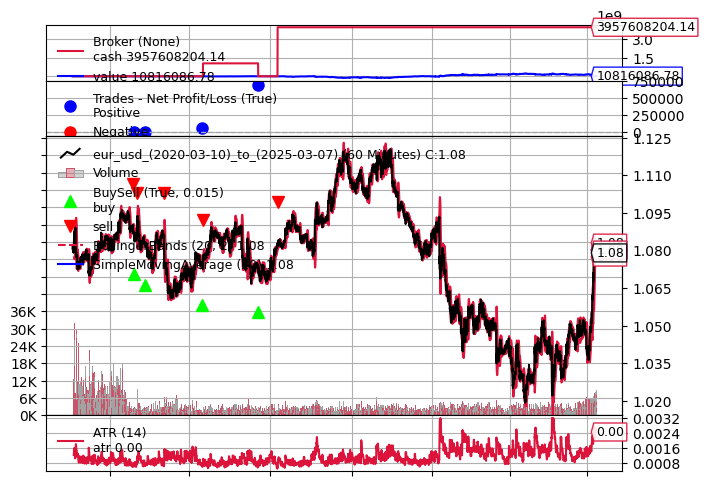

In [14]:
cerebro.plot(iplot=False)
plt.show()

In [15]:
strategy = results[0]

# Extract trade data
dates, prices, trades = zip(*strategy.trade_log) if strategy.trade_log else ([], [], [])
equity_dates = data.datetime.array[:len(strategy.equity_curve)]

# Create Matplotlib Graphs
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Price & Trades Plot ---
axes[0].plot(data.datetime.array, data.close.array, label="Close Price", color="black", linewidth=1)
axes[0].plot(data.datetime.array, strategy.bb.lines.bot.array, label="Lower BB", color="blue", linestyle="dashed")
axes[0].plot(data.datetime.array, strategy.bb.lines.top.array, label="Upper BB", color="red", linestyle="dashed")
axes[0].plot(data.datetime.array, strategy.sma.array, label="SMA", color="orange", linestyle="solid")

# Plot Buy/Sell Markers
for d, p, t in zip(dates, prices, trades):
    color = "green" if t == "buy" else "red"
    marker = "^" if t == "buy" else "v"
    axes[0].scatter(d, p, color=color, marker=marker, s=100, label=t.capitalize() if t in ["buy", "sell"] else "")

axes[0].set_ylabel("Price")
axes[0].set_title("Trading Strategy Execution")
axes[0].legend()
axes[0].grid()

# --- Equity Curve Plot ---
axes[1].plot(equity_dates, strategy.equity_curve, label="Equity Curve", color="purple", linewidth=2)
axes[1].set_ylabel("Portfolio Value ($)")
axes[1].set_xlabel("Date")
axes[1].set_title("Equity Growth Over Time")
axes[1].legend()
axes[1].grid()

plt.show()

AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BollingerATRStrat' object has no attribute 'trade_log'